#K-Means Clustering

In [12]:
%matplotlib inline
import numpy as np
import sklearn.cluster
import sklearn.feature_extraction
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import bottleneck as bn
import itertools
from sklearn.cross_validation import KFold
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

###Fake Testing

In [47]:
# run k-means clustering on M, for each k values in k_vals
def k_mean_test(M, k_vals):
    results = []
    # sum of squared Euclidean distances from mean
    var = sum(np.var(M,0))*len(M)
    # loop through all k values provided
    for k in k_vals:
        # fit k-means clusterer
        fit = sklearn.cluster.KMeans(n_clusters=k).fit(M)
        # sum of squared Euclidean distance from cluster center
        within_var = sum(map(lambda r : min(r)**2, fit.transform(M)))
        results.append((fit, k, within_var/var))
    return results

###Multi-Purpose Functions for Evaluating Models
We can start by defining a couple of generally useful functions to evaluate the correctness of any given set of predictions.

In [16]:
# computes % accuracy rate of predictions, given a vector of predicted categories and a vector of actual categories
def accuracy(predicted,actual):
    # boolean array of Trues for correct predictions and Falses for incorrect predictions
    correct = map(lambda (c1,c2) : c1==c2, zip(predicted,actual))
    return float(sum(correct)) / len(correct)

Another way to measure the success of an unsupervised algorithm is the Rand Index, which is described in much more detail in the NMF notebook. In short, we can look at every possible pair of cases, and mark that pair as a 'success' if the k-means clustering dealt with the pair successfully (i.e. either placed them into the same cluster when they were supposed to be together, or placed them in separate clusters when they were supposed to be separate), and a 'failure' otherwise. Then, the Rand Index is defined as $\frac{\text{number of successes}}{\text{number of successes} + \text{number of failures}}$.

In [17]:
# computes the Rand Index, given a vector of predicted categories and a vector of actual categories
def rand_index(predicted,actual):
    # use itertools to create pairs of documents, using the k-means clusters and SCDB categories
    cluster_pairs_pred = itertools.product(predicted,predicted)
    cluster_pairs_actual = itertools.product(actual,actual)
    # loop through all document pairs to compute tp, tn, fp, and fn
    (tp,tn,fp,fn) = 0, 0, 0, 0
    for pair1,pair2 in zip(cluster_pairs_pred, cluster_pairs_actual):
        if (pair1[0]==pair1[1]):
            if (pair2[0]==pair2[1]):
                tp += 1
            else:
                fp += 1
        else:
            if (pair2[0]==pair2[1]):
                fn += 1
            else:
                tn += 1
    
    # compute and output Rand Index using formula from above
    rand_index_train = float(tp+tn)/(tp+tn+fp+fn)
    return rand_index_train

###Fitting Noun Model with Training Data

We start by fitting a model with just nouns on the training data. First, we apply a TF-IDF transform (which is described elsewhere in our project) to the data, to place a higher importance on words that are not extremely common.

In [3]:
%%time
# read in training data from csv
noun_train_mat = np.loadtxt("noun_train_mat.csv", delimiter = ",")
# use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(noun_train_mat)
noun_train_mat = tf_idf_fit.transform(noun_train_mat).toarray()

Wall time: 34.2 s


Next, we can fit a k-means model with 14 clusters on the training data. We can also compute and output the ratio of within-cluster SSQ to total SSQ, where within-cluster SSQ is defined as the total squared distance of each point to the center of its assigned cluster across all training data, and total SSQ is the total squared distance of each point to the mean of all of the data.

In [5]:
%%time
kmeans_fit = sklearn.cluster.KMeans(n_clusters=14).fit(noun_train_mat)
# compute the ratio of within-group sum of squared distances to cluster mean to total sum of squared distances to overall mean
ssq = sum(np.var(noun_train_mat,0))*len(noun_train_mat)
within_ssq = sum(map(lambda r : min(r)**2, kmeans_fit.transform(noun_train_mat)))
print within_ssq / ssq

0.929438894343
Wall time: 18.4 s


That ratio gives us an indication of how well the clusters predict the variance in the data. However, the fact that it is very high is not a cause of concern by itself; we are dealing with a vector space whose dimension is well over 10,000, so it would be unrealistic to expect the variance to fall dramatically if we use 14 clusters, even if those clusters are very meaningful and useful.

We can use that k-means fit to divide the training data cases into 14 documents.

In [6]:
%%time
# use the fit above to cluster the data
clusters = kmeans_fit.predict(noun_train_mat)
cluster_lists = [[i for i,j in enumerate(clusters) if j==cluster] for cluster in range(14)]
print 'Number of documents per cluster:', [len(clusters[clusters==i]) for i in range(14)]

Number of documents per cluster: [44, 45, 39, 346, 60, 166, 43, 24, 70, 90, 63, 30, 46, 21]
Wall time: 82 ms


###Key Words for Each Cluster

Using the TF-IDF-transformed `noun_train_mat` matrix from above, we can find out the words that are most prominent for each cluster.

In [7]:
# load vocab from csv
noun_vocab = np.loadtxt("noun_vocab.csv", delimiter=",", dtype="str")
noun_vocab = [(int(i),j) for i,j in noun_vocab]
id2noun = dict(noun_vocab)

In [8]:
# find and output the 5 most important words for each category
num_best = 5
best_indices = map(lambda cases : list(bn.argpartsort(-sum(noun_train_mat[cases]),num_best)[0:num_best]), cluster_lists)
best_words = [[id2noun[i] for i in lst] for lst in best_indices]
best_words

[['commission', 'rate', 'commerce', 'gas', 'carrier'],
 ['trial', 'jury', 'court', 'petitioner', 'judge'],
 ['act', 'liability', 'employer', 'railroad', 'employee'],
 ['court', 'district', 'law', 'state', 'petitioner'],
 ['state', 'tax', 'property', 'income', 'court'],
 ['land', 'respondent', 'act', 'court', 'water'],
 ['conviction', 'offense', 'court', 'conspiracy', 'felony'],
 ['alien', 'immigration', 'deportation', 'nationality', 'act'],
 ['court', 'sentence', 'counsel', 'habea', 'trial'],
 ['court', 'search', 'trial', 'petitioner', 'amendment'],
 ['union', 'labor', 'board', 'employee', 'bargain'],
 ['student', 'school', 'board', 'education', 'court'],
 ['pension', 'plan', 'benefit', 'security', 'child'],
 ['master', 'decree', 'court', 'orig ', 'u s ']]

Just as with most of the other models, these word groups are generally very meaningful and useful; for example, `['trial', 'jury', 'court', 'petitioner', 'judge']` clearly must include cases relate to judicial law, while `['conviction', 'offense', 'court', 'conspiracy', 'felony']` deals with criminal law.

###Comparing with Supreme Court Database's Topic Areas

To evaluate the effectiveness of the algorithm (on the training data), we need to include the Supreme Court Database data. As before, the computations and visualizations in this section are very similar to those in the NMF notebook.

In [9]:
# read in SC Database's issue areas from csv
train_issue_areas = np.loadtxt("train_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
train_issue_areas = train_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in train_issue_areas]) for i in range(14)]

Number of documents per category: [238, 186, 84, 43, 10, 9, 56, 234, 126, 57, 10, 30, 4, 0]


In [22]:
topic_areas = ['Criminal Procedure', 'Civil Rights', 'First Amendment', 'Due Process', 'Privacy', 'Attorneys', 'Unions',
               'Economic Activity', 'Judicial Power', 'Federalism', 'Interstate Relations', 'Federal Taxation', 'Miscellaneous',
               'Private Action']

We need to take the 14 k-means clusters and map each one of them to SCDB topic area, so that we can place each data point into a Supreme Court Database category. Here, we use a method that is based on 'assignment method 1' in the NMF notebook. The algorithm is described in detail there; in short, for each k-means cluster, we assign that cluster to the SCDB category that has the most cases in common with the k-means cluster.

In [23]:
# create a 14x14 matrix (where each row is a k-means cluster and each column is an SCDB cluster) measuring the degree of
# related-ness between each cluster pair
compare_mat = map(lambda r : map(int, r), np.zeros((14,14)))
# first, assign the (i,j) element in the matrix to the number of cases in k-means cluster i and SCDB cluster j, for each (i,j)
for i,j in zip(clusters, train_issue_areas):
    compare_mat[i][j] += 1
# normalize each row to have a sum of 1
compare_mat = map(lambda row : map(float,row) / sum(row), np.array(compare_mat))

# assign each k-means cluster to a (not necessarily unique) SCDB cluster by picking the highest element of each row of compare_mat
assignments = map(np.argmax, compare_mat)
print assignments

[7, 0, 7, 8, 7, 7, 0, 1, 0, 0, 6, 1, 1, 10]


Now, we can use that output to convert the k-means clusters produced from the model above into an assignment of each case to an SCDB topic area. We can then produce the accuracy rate (defined as the proportion of cases that are assigned to the correct SCDB category) and a Rand Index for the prediction.

In [24]:
# use the assignments above to convert the clusters into equivalent SCDB categories for each document
new_clusters = map(lambda cluster : assignments[cluster], clusters)
# compute and output accuracy rate
print 'Accuracy:', accuracy(new_clusters, train_issue_areas)
print 'Rand Index:', rand_index(new_clusters, train_issue_areas)

Accuracy: 0.497700091996
Rand Index: 0.754519626023


####Visualizing Results on Training Data

The following visualizations are all based directly on on the NMF notebook, and are described in depth in that notebook. First, we produce a heat map that illustrates the clustering above, by counting how many cases were clustered into SCDB area `i` and were actually in SCDB topic area `j`, for each pair of topic areas `(i,j)`.

C:\Users\Madhu\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


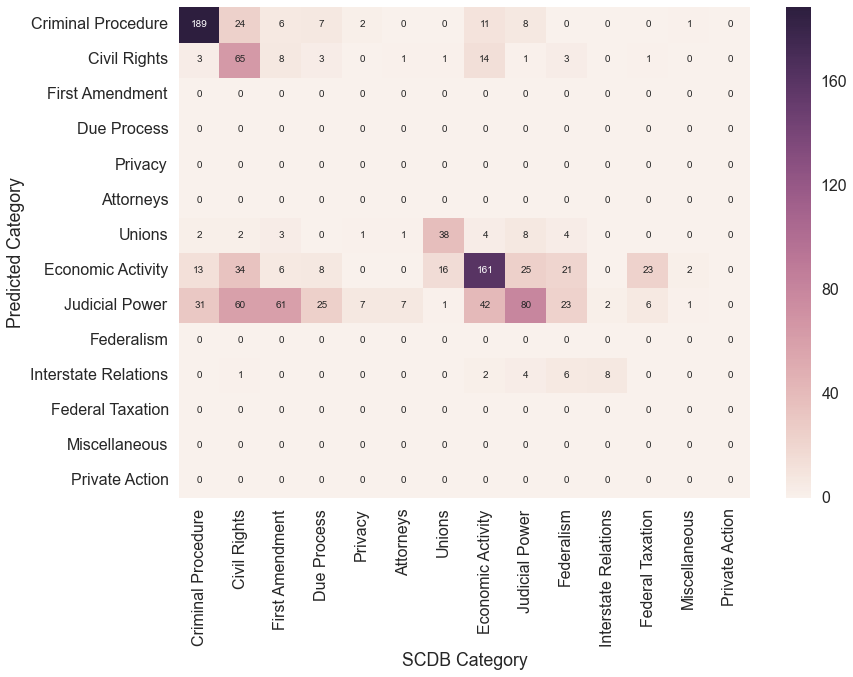

In [25]:
compare_mat_new = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(new_clusters, train_issue_areas):
    compare_mat_new[i][j] += 1
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas, fmt='d')
sns.axlabel('SCDB Category', 'Predicted Category')

The next heat map is the same as above, but with each column normalized to have a sum of 1, which helps us analyze percent accuracy rates within each topic area.

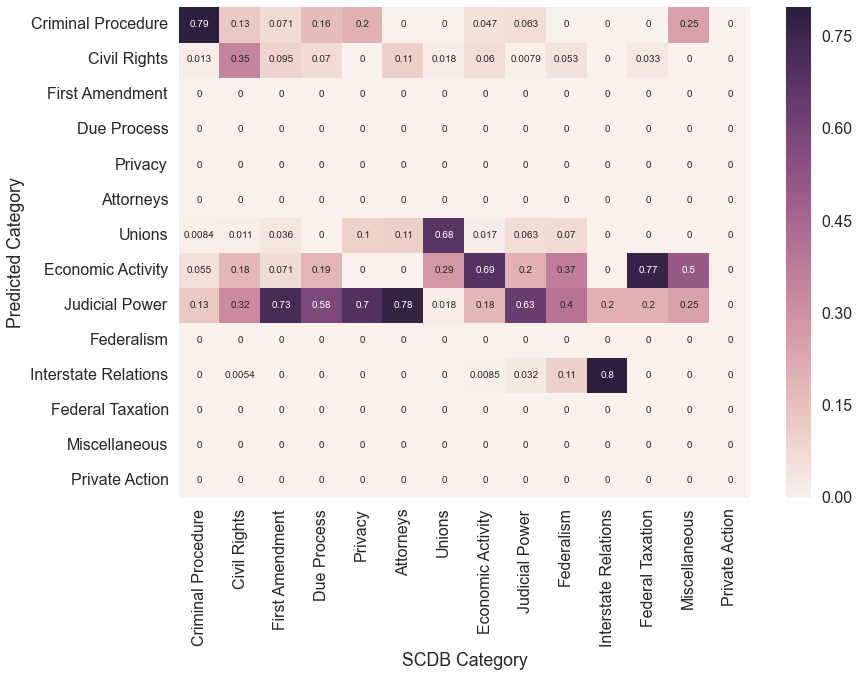

In [26]:
# normalize each column to have a sum of 1
compare_mat_new = np.array(compare_mat_new).T
compare_mat_new = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat_new))
compare_mat_new = np.array(compare_mat_new).T

# produce a heat map of the new normalized matrix
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas)
sns.axlabel('SCDB Category', 'Predicted Category')

Once again, this helps us understand the most common mistakes made by the algorithm. For example, federal taxation cases are often mis-classified as economic activity, and First Amendment, due process, privacy, and attorneys cases are all frequently mis-classified as judicial power cases.

The following bar chart displays the accuracy rate of the k-means clustering for the cases within each SCDB category, for the training data.

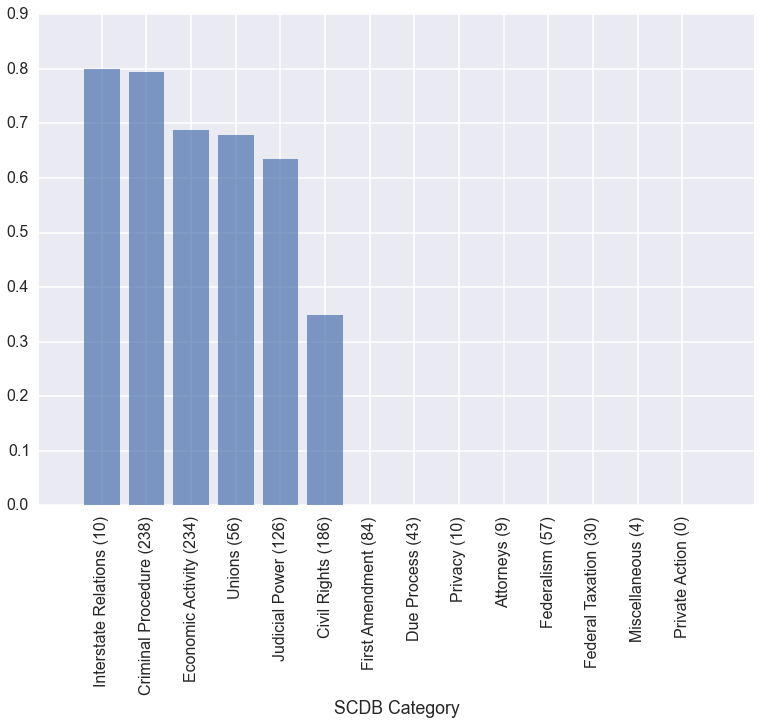

In [27]:
# sort the SCDB topic areas based on accuracy on training data
ordered = zip(topic_areas, [sum([x==i for x in train_issue_areas]) for i in range(14)], np.diag(compare_mat_new), range(14))
ordered.sort(key = lambda (topic,num,acc,ind) : -acc)
ordered_topics = list(zip(*ordered)[0])
counts = list(zip(*ordered)[1])
topic_accuracies = list(zip(*ordered)[2])
order = list(zip(*ordered)[3])

# plot a bar chart of the accuracy of the clustering algorithm within each topic area
fig, ax = plt.subplots()
ax.bar(np.arange(14)+1, topic_accuracies, alpha=0.7, linewidth=0)
ax.set_xticks(np.arange(14)+1.4)
ax.set_xticklabels(map(lambda (count,topic) : "%s (%s)" % (topic,count), zip(counts,ordered_topics)), rotation='vertical')
ax.set_xlabel('SCDB Category')
print

As before, this bar chart shows that the accuracy rate is high for some of the largest categories, but is zero for several categories (since no cases end up being placed into those clusters). This is worrying, especially since some of the larger areas (like First Amendment) are also left out.

###Cross-Validation

In [28]:
def cv_results_unsupervised(predict, x, y, score_func, nfolds=5):
    results = []
    for train, test in KFold(len(y), nfolds):
        pred = predict(x[train],y[train],x[test]) # compute predictions
        results += [score_func(pred, y[test])] # evaluate score function on held-out data
    return results

In [30]:
def fit_transform(x_train, y_train, x_test, n_components):
    # compute an NMF fit on x_train, and produce
    kmeans_fit = sklearn.cluster.KMeans(n_clusters=n_components).fit(x_train)
    clusters_train = kmeans_fit.predict(x_train)
    
    # create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
    # related-ness between each cluster pair
    compare_mat = map(lambda r : map(int, r), np.zeros((n_components,14)))
    # first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
    for i,j in zip(clusters_train, y_train):
        compare_mat[i][j] += 1
    assignments = map(np.argmax, compare_mat)
    
    clusters_test = kmeans_fit.predict(x_test)
    # use the assignments above to convert the clusters into equivalent SCDB categories for each document
    new_clusters = map(lambda cluster : assignments[cluster], clusters_test)
    return new_clusters

In [ ]:
%%time
num_clusters_lst = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

results = dict()
for k in num_clusters_lst:
    print 'Testing with %d clusters' % k
    results[k] = cv_results_unsupervised(lambda x,y,z : fit_transform(x,y,z,k), noun_train_mat, train_issue_areas,
                                         lambda pred,act : (accuracy(pred,act), rand_index(pred,act)), nfolds=5)

Testing with 5 clusters
Testing with 10 clusters
Testing with 15 clusters
Testing with 20 clusters

In [45]:
# output 2 dictionaries containing the average accuracy and average Rand Index for each value of n_clusters, based on the
# cross-validation results from above
results_accuracies = dict()
results_rand_ind = dict()
for k in results.keys():
    accuracy_k, rand_index_k = zip(*results[k])
    results_accuracies[k] = np.mean(accuracy_k)
    results_rand_ind[k] = np.mean(rand_index_k)
print results_accuracies
print results_rand_ind

{35: 0.46359374762187416, 5: 0.39647352480099846, 40: 0.45256685387273032, 10: 0.44155264346123207, 45: 0.47373788107087961, 15: 0.46456275461800328, 50: 0.43329325398637303, 20: 0.42136076992932847, 25: 0.48664444545911145, 30: 0.46454246127777016}
{35: 0.72918659109209383, 5: 0.560372334315411, 40: 0.73956925611081792, 10: 0.67207966877698888, 45: 0.76664454467727727, 15: 0.70858188658911969, 50: 0.72651792940411486, 20: 0.72282405158360519, 25: 0.70864455123030601, 30: 0.70801678475905894}


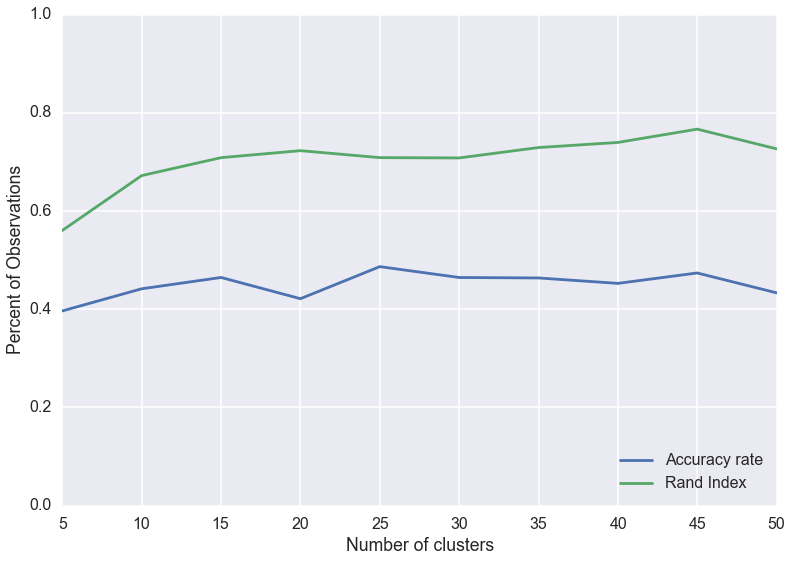

In [46]:
accuracies = results_accuracies.items()
accuracies.sort(key = lambda (a,b) : a)
plt.plot(*zip(*accuracies), label='Accuracy rate')

rand = results_rand_ind.items()
rand.sort(key = lambda (a,b) : a)
plt.plot(*zip(*rand), label='Rand Index')

plt.ylim((0,1))
plt.xlabel('Number of clusters')
plt.ylabel('Percent of Observations')
plt.legend(loc = 'lower right')

###Applying Model to Test Data

In [12]:
%%time
# read in test data from csv
noun_test_mat = np.loadtxt("noun_test_mat.csv", delimiter = ",")
# use TF-IDF fit from training data to scale each document's vector to have norm 1 and place a lower weight on very common words
noun_test_mat = tf_idf_fit.transform(noun_test_mat).toarray()

Wall time: 16.5 s


In [13]:
%%time
# use k-means fit from training data to cluster test observations
clusters_test = kmeans_fit.predict(noun_test_mat)
cluster_lists_test = [[i for i,j in enumerate(clusters_test) if j==cluster] for cluster in range(14)]
print 'Number of documents per cluster:', [len(clusters_test[clusters_test==i]) for i in range(14)]
# uncomment this loop to see a list of documents by cluster
#for cluster in range(14):
#    print
#    print 'Documents in category %s:' % cluster, cluster_lists_test[cluster]

Number of documents per cluster: [6, 36, 10, 68, 47, 26, 29, 5, 21, 26, 10, 7, 185, 9]
Wall time: 59 ms


###Compare Test Data Results to SC Database Categories

In [14]:
# read in SC Database's issue areas from csv
noun_test_issue_areas = np.loadtxt("noun_test_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
noun_test_issue_areas = noun_test_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in noun_test_issue_areas]) for i in range(14)]

Number of documents per category: [104, 95, 26, 22, 3, 7, 18, 96, 63, 25, 5, 17, 4, 0]


In [15]:
# use the assignments above to convert the clusters into equivalent SCDB categories for each document
new_clusters_test = map(lambda cluster : assignments[cluster], clusters_test)
# compute and output accuracy rate
correct_test = map(lambda (c1,c2) : c1==c2, zip(new_clusters_test, noun_test_issue_areas))
print float(sum(correct_test)) / len(correct_test)

0.468041237113


###Use Rand Index to Compute Accuracy on Test Data

In [16]:
%%time
if 'cluster_test_pairs_model' in globals():
    del cluster_test_pairs_model
if 'cluster_test_pairs_actual' in globals():
    del cluster_test_pairs_actual

# use itertools to create pairs of documents, using the k-means clusters and SCDB categories
cluster_test_pairs_model = itertools.product(clusters_test, clusters_test)
cluster_test_pairs_actual = itertools.product(noun_test_issue_areas, noun_test_issue_areas)
# loop through all document pairs to compute tp, tn, fp, and fn
(tp,tn,fp,fn) = 0, 0, 0, 0
for pair1,pair2 in zip(cluster_test_pairs_model, cluster_test_pairs_actual):
    if (pair1[0]==pair1[1]):
        if (pair2[0]==pair2[1]):
            tp += 1
        else:
            fp += 1
    else:
        if (pair2[0]==pair2[1]):
            fn += 1
        else:
            tn += 1

# output tp, tn, fp, and fn
print tp,tn,fp,fn
# compute and output Rand index using formula from above
rand_index_test = float(tp+tn)/(tp+tn+fp+fn)
print rand_index_test

10137 164460 35242 25386
0.742255287491
Wall time: 385 ms
